In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import glob
from keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten

In [3]:
TRAIN_ = './arabic-chars-mnist/train'
TEST_= './arabic-chars-mnist/test'
train_images = [TRAIN_+i for i in os.listdir(TRAIN_)] 
test_images = [TEST_+i for i in os.listdir(TEST_)]

In [4]:
def get_label(fname):
    parts = re.split('/',fname)[-1]
    part=re.split(r'(\d+)',parts)
    return part[0]

In [6]:
path_label_train=[]
for filename in glob.glob('./arabic-chars-mnist/train/*.jpg'):
    path_label_train.append([filename,get_label(filename)])
df_train=pd.DataFrame(path_label_train,columns = ['path','label'])
df_train.head(10)

,path,label
0,./arabic-chars-mnist/train\ain10216.jpg,train\ain
1,./arabic-chars-mnist/train\ain10217.jpg,train\ain
2,./arabic-chars-mnist/train\ain10218.jpg,train\ain
3,./arabic-chars-mnist/train\ain10219.jpg,train\ain
4,./arabic-chars-mnist/train\ain10220.jpg,train\ain
5,./arabic-chars-mnist/train\ain10221.jpg,train\ain
6,./arabic-chars-mnist/train\ain10222.jpg,train\ain
7,./arabic-chars-mnist/train\ain10223.jpg,train\ain
8,./arabic-chars-mnist/train\ain1032.jpg,train\ain
9,./arabic-chars-mnist/train\ain1033.jpg,train\ain


In [7]:
path_test=[]
for filename in glob.glob('./arabic-chars-mnist/test/*.jpg'): 
    path_test.append(filename)

In [8]:
df_test=pd.DataFrame(path_test,columns = ['path'])
df_test['label']=0
df_test.head()

,path,label
0,./arabic-chars-mnist/test\ain1042.jpg,0
1,./arabic-chars-mnist/test\ain1043.jpg,0
2,./arabic-chars-mnist/test\ain1098.jpg,0
3,./arabic-chars-mnist/test\ain1099.jpg,0
4,./arabic-chars-mnist/test\ain1154.jpg,0


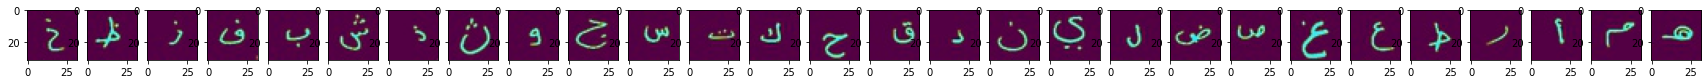

In [9]:
fig, ax = plt.subplots(1, 28, figsize=(30, 12))
for i,name in enumerate(set(df_train['label'])):
    sample = df_train[df_train['label'] == name].sample(1)
    image_path=sample['path'].item()
    X = cv2.imread(image_path)
    ax[i].imshow(X)

In [10]:
def read_img(path):
    img=cv2.imread(path)
    return img

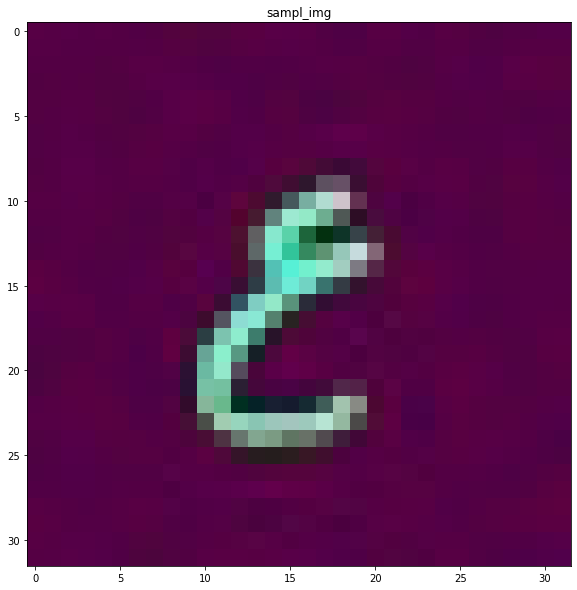

In [13]:
N = df_train.shape[0]
x_train = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, path in enumerate((df_train['path'])):
    x_train[i, :, :, :] = read_img(path)
fig=plt.figure(figsize=(20, 10))
plt.title('sampl_img')
plt.imshow(x_train[0])

In [12]:
N = df_test.shape[0]
x_test = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, path in enumerate((df_test['path'])):
    x_test[i, :, :, :] = read_img(path)

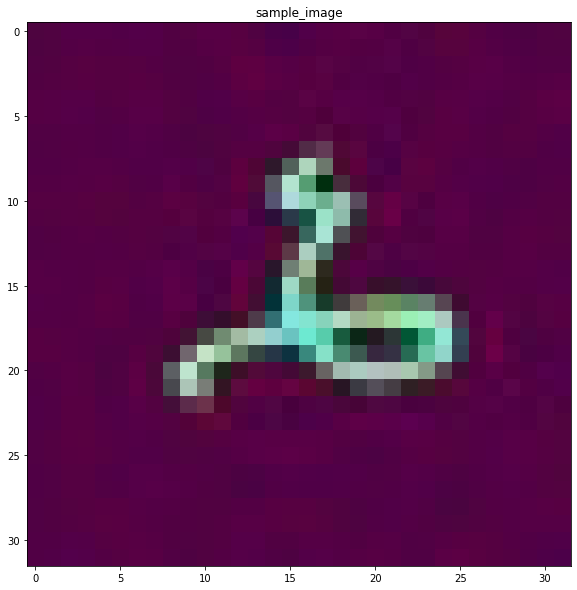

In [14]:
fig=plt.figure(figsize=(20, 10))
plt.title('sample_image')
plt.imshow(x_test[19])

In [15]:
print(x_train[10].shape)
print(x_test[40].shape)

(32, 32, 3)
(32, 32, 3)


In [16]:
lb=LabelEncoder()
y_train=lb.fit_transform(df_train['label'])
y_train=to_categorical(y_train, num_classes=28)

In [17]:
def create_model(activation='relu', optimizer='adam', kernel_initializer='he_normal'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3), activation= activation, kernel_initializer=kernel_initializer))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation= activation, kernel_initializer=kernel_initializer))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(32, activation= activation, kernel_initializer=kernel_initializer, kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(28, activation='softmax'))
    model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                   metrics=['accuracy'])
    return model

In [18]:
model=create_model()                                                          
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

In [19]:
early_stop = EarlyStopping(
                monitor='val_loss', 
                mode='auto',
                verbose=1, 
                patience=8 
              )

In [20]:
history=model.fit(x_train, y_train, 
                    validation_split=0.3,
                    callbacks=[early_stop],
                    epochs=1100, batch_size=64, verbose=1)

Epoch 1/1100
147/147 [==============================] - 13s 80ms/step - loss: 2.5894 - accuracy: 0.4345 - val_loss: 4.7210 - val_accuracy: 0.0255
Epoch 2/1100
147/147 [==============================] - 12s 79ms/step - loss: 1.2804 - accuracy: 0.7528 - val_loss: 5.4745 - val_accuracy: 0.0372
Epoch 3/1100
147/147 [==============================] - 12s 80ms/step - loss: 0.8260 - accuracy: 0.8523 - val_loss: 6.2398 - val_accuracy: 0.0355
Epoch 4/1100
147/147 [==============================] - 12s 79ms/step - loss: 0.6074 - accuracy: 0.8986 - val_loss: 6.5151 - val_accuracy: 0.0377
Epoch 5/1100
147/147 [==============================] - 12s 79ms/step - loss: 0.5065 - accuracy: 0.9148 - val_loss: 7.4424 - val_accuracy: 0.0265
Epoch 6/1100
147/147 [==============================] - 12s 80ms/step - loss: 0.4467 - accuracy: 0.9304 - val_loss: 7.7641 - val_accuracy: 0.0389
Epoch 7/1100
147/147 [==============================] - 12s 80ms/step - loss: 0.4040 - accuracy: 0.9444 - val_loss: 8.0008 -

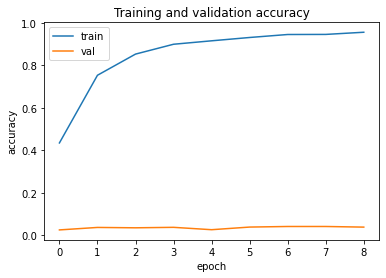

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Text(0.5, 0, 'epoch')

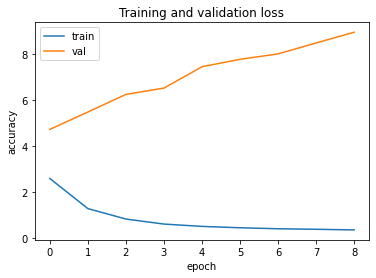

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [23]:
model.save('HAJARhandWAr.h5')

In [24]:
pred=model.predict(x_test)
res=np.argmax(pred,axis=1)
res=lb.inverse_transform(res)
res[:5]

105/105 [==============================] - 1s 12ms/step


array(['train\\ain', 'train\\ain', 'train\\ain', 'train\\ain',
       'train\\ain'], dtype=object)

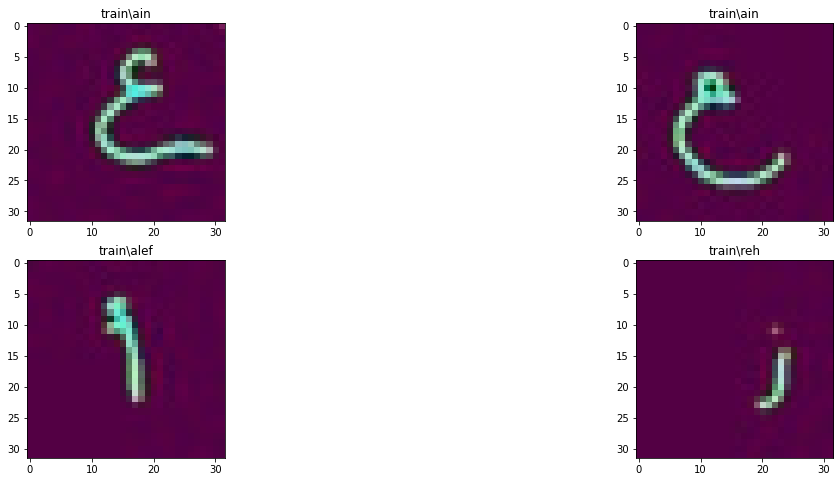

In [25]:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].imshow(x_test[2])
axs[0, 0].set_title(res[2])
axs[0, 1].imshow(x_test[8])
axs[0, 1].set_title(res[8])
axs[1, 0].imshow(x_test[232])
axs[1, 0].set_title(res[232])
axs[1, 1].imshow(x_test[3305])
axs[1, 1].set_title(res[3305])
plt.show()

In [27]:
df_test['label']=res
df_test.head(10)

,path,label
0,./arabic-chars-mnist/test\ain1042.jpg,train\ain
1,./arabic-chars-mnist/test\ain1043.jpg,train\ain
2,./arabic-chars-mnist/test\ain1098.jpg,train\ain
3,./arabic-chars-mnist/test\ain1099.jpg,train\ain
4,./arabic-chars-mnist/test\ain1154.jpg,train\ain
5,./arabic-chars-mnist/test\ain1155.jpg,train\ain
6,./arabic-chars-mnist/test\ain1210.jpg,train\ain
7,./arabic-chars-mnist/test\ain1211.jpg,train\ain
8,./arabic-chars-mnist/test\ain1266.jpg,train\ain
9,./arabic-chars-mnist/test\ain1267.jpg,train\ain
